In [1]:
#Libraries
import util_mnist_reader
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn import metrics, cluster, model_selection, mixture
from keras import layers, models, initializers, optimizers, utils, backend
from scipy.stats import mode

Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarn

In [2]:
#Read Fashion MNIST dataset
print('Reading dataset')
X_train, y_train = util_mnist_reader.load_mnist('../data/fashion', kind='train')
X_test, y_test = util_mnist_reader.load_mnist('../data/fashion', kind='t10k')

#Preprocessing of data
print('Preprocessing and normalization of data')

#Splitting the training data into training and validation datasets
X_train, X_valid, y_train, y_valid= model_selection.train_test_split(X_train, y_train, test_size=0.25, random_state=13)

#Normalization of data
X_train = X_train.reshape(len(X_train),-1)
X_train = X_train.astype(float) / 255.0
X_valid = X_valid.reshape(len(X_valid),-1)
X_valid = X_valid.astype(float) / 255.0
X_test = X_test.reshape(len(X_test),-1)
X_test = X_test.astype(float) / 255.0

Reading dataset
Preprocessing and normalization of data


In [3]:
def kmeans(X, y, k):
    hypo = cluster.KMeans(n_clusters = k)
    clusters = hypo.fit_predict(X)
    inertia = hypo.inertia_
        
    #Mapping the labels found to the ground truth
    labels = np.zeros_like(clusters)
    for i in range(k):
        mask = (clusters == i)
        labels[mask] = mode(y[mask])[0]
        
    #Computing the accuracy for the given k value
    acc = metrics.accuracy_score(y, labels)
    
    return [inertia, labels, acc]

In [4]:
def elbow_method(inertia):
    #Elbow method
    print('')
    print('Elbow graph:')
    #plt.subplots(121)
    plt.plot(range(9,12), inertia)
    plt.xlabel('Number of clusters')
    plt.show()

---------Task 1-----------

For k: 9
Accuracy :  0.5539777777777778

Confusion matrix :
[[2606  151    0    0  127  438 1170    1   40    0]
 [ 182 4065    0    0   50  111   94    0    3    0]
 [  88    6    0    0 2637  382 1361    1   35    0]
 [1230 2479    0    0   32  386  392    0    9    1]
 [ 662  117    0    0 2669  190  825    0   37    0]
 [   3    0    0    0    0 2967   30 1133   22  370]
 [ 810   49    0    0 1477  543 1579    4   66    2]
 [   0    0    0    0    0  422    1 3808    4  223]
 [  17   24    0    0  188  358  170  222 3495    6]
 [   3    3    0    0    5  144   50  479    6 3740]]
For k: 10
Accuracy :  0.5531111111111111

Confusion matrix :
[[2604  151    0    0  127  458 1154    1   38    0]
 [ 182 4063    0    0   50  115   92    0    3    0]
 [  87    6    0    0 2633  392 1357    1   34    0]
 [1228 2476    0    0   32  400  383    0   10    0]
 [ 661  119    0    0 2667  195  821    0   37    0]
 [   2    0    0    0    0 2845   24 1092   15  547]
 [

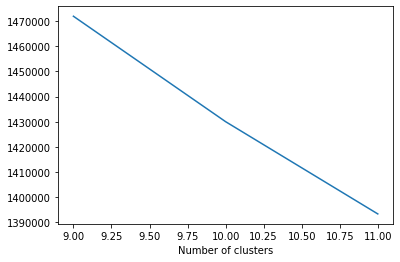

Test accuracy:  0.5455
End of task 1


In [5]:
def task1(X, y, X_test, y_test):
    print("---------Task 1-----------")
    print('')
    score = []
    inertia = []
    centroids = []
    for k in range(9, 12):
        print('For k:',k)
        
        #Computing the Kmeans for given data
        [inertia_, labels, acc] = kmeans(X, y, k)
        
        inertia.append(inertia_)
        score.append(acc)
        print('Accuracy : ', acc)
        
        #Determining the confusion matrix for the given k value
        print('')
        print('Confusion matrix :')
        mat = metrics.confusion_matrix(y, labels)
        print(mat)
        
    elbow_method(inertia)
            
    #Testing 
    [_, _, acc] = kmeans(X_test, y_test, 10)
    print('Test accuracy: ', acc)
    
task1(X_train, y_train, X_test, y_test)
print('End of task 1')

In [6]:
def auto_encoder(X_train, X_valid, X_test):
    batch_size = 200
    epochs = 30
    
    #Encoder of autoencoder
    autoencoder = models.Sequential()
    autoencoder.add(layers.Conv2D(15, kernel_size=3, padding='same', activation='relu', input_shape=(28,28,1)))
    autoencoder.add(layers.MaxPool2D((2,2), padding='same'))
    autoencoder.add(layers.Dropout(0.2))
    autoencoder.add(layers.Conv2D(8, kernel_size=3, padding='same', activation='relu'))

    #Decoder of autoencoder
    autoencoder.add(layers.MaxPool2D((2,2), padding='same'))
    autoencoder.add(layers.Dropout(0.2))
    autoencoder.add(layers.Conv2D(8, kernel_size=3, padding='same', activation='relu'))
    autoencoder.add(layers.UpSampling2D((2,2)))
    autoencoder.add(layers.Dropout(0.2))
    autoencoder.add(layers.Conv2D(15, kernel_size=3, padding='same', activation='relu'))
    autoencoder.add(layers.UpSampling2D((2,2)))
    autoencoder.add(layers.Dropout(0.2))
    autoencoder.add(layers.Conv2D(1, kernel_size=3, padding='same', activation='relu'))
    
    #Model compilation and training
    autoencoder.compile(optimizer='adam', loss="mse", metrics = ['accuracy'])
    autoencoder.summary()
    auto_encoded = autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, X_valid), verbose=1)
    
    # Training Loss vs Validation Loss
    plt.plot(auto_encoded.history['loss'])
    plt.plot(auto_encoded.history['val_loss'])
    plt.title('AutoEncoder loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()
    
    #Testing the autoencoder
    restored_testing_dataset = autoencoder.predict(X_test)
    
    #encoder extracted from autoencoder
    encoder = backend.function([autoencoder.layers[0].input], [autoencoder.layers[4].output])
    
    #Showing the output of a sample 
    index = 10
    encoded_valid = encoder([X_test])[0].reshape(-1,7*7*8)
    decoded_valid = autoencoder.predict(X_test)
    
    #Saving the model and the weights
    print('Saving the model')
    autoencoder.save_weights("autoencoder.h5")
    model_json = autoencoder.to_json()
    with open("autoencoder.json", "w") as json_file:
        json_file.write(model_json)
    return encoder

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 15)        150       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 15)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 15)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1088      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
__________

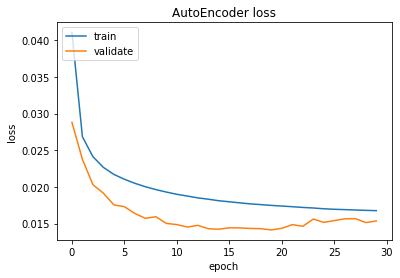

Saving the model


In [7]:
#Training autoencoder and saving the model
X_train = X_train.reshape(-1, 28, 28, 1)
X_valid = X_valid.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)
encoder = auto_encoder(X_train, X_valid, X_test)

In [16]:
def task2(X_train, y_train, X_valid, y_valid, X_test, y_test):
    print("---------Task 2-----------")
    print('')
    
    #Loading the weights into new model
    print("Loading the model from disk")
    
    # load json and create model
    json_file = open('autoencoder.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = models.model_from_json(loaded_model_json)
    
    # load weights into new model
    loaded_model.load_weights("autoencoder.h5")
    loaded_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    decoded_images = loaded_model.predict(X_valid)
    
    #Determine the encoded images
    print('Encoding images')
    encoder = backend.function([loaded_model.layers[0].input], [loaded_model.layers[4].output])
    encoded_images = encoder([X_valid])[0].reshape(-1,7*7*8)

    #Computing the Kmeans for encoded data
    print('Computing the Kmeans for encoded data')
    [_, labels, acc] = kmeans(encoded_images, y_valid, 10)
    print('Accuracy : ', acc)
    
    #Determining the confusion matrix for the given k value
    print('')
    print('Confusion matrix :')
    mat = metrics.confusion_matrix(y_valid, labels)
    print(mat)
    
task2(X_train, y_train, X_valid, y_valid, X_test, y_test)
print('End of task 2') 

---------Task 2-----------

Loading the model from disk
Encoding images
Computing the Kmeans for encoded data
Accuracy :  0.5574666666666667

Confusion matrix :
[[ 604    0    0  137   20    5  635    2   64    0]
 [   0 1124    0   56   11    0  292    0   12    0]
 [   5    0    0   24  649    4  450    0  358    0]
 [  24   17    0  844   18    0  531    0   37    0]
 [   0    2    0  180  742    0  254    0  322    0]
 [   0    0    0    3    0 1202   22  170   11   67]
 [ 131    0    0   90  316   11  657    0  265    0]
 [   0    0    0    0    0  545    0  947    0   50]
 [   0    0    0   18   32  176  152   79 1060    3]
 [   0    0    0    2    2  147   20  201   16 1182]]
End of task 2


In [9]:
def task3(X_train, y_train, X_valid, y_valid, X_test, y_test):
    print("---------Task 3-----------")
    print('')
    
    #Loading the weights into new model
    print("Loading the model from disk")
    
    # load json and create model
    json_file = open('autoencoder.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = models.model_from_json(loaded_model_json)
    
    # load weights into new model
    loaded_model.load_weights("autoencoder.h5")
    loaded_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    decoded_images = loaded_model.predict(X_valid)
    
    #Determine the encoded images
    print('Encoding images')
    encoder = backend.function([loaded_model.layers[0].input], [loaded_model.layers[4].output])
    encoded_images = encoder([X_valid])[0].reshape(-1,7*7*8)
    
    #Computing the GMM clustering for encoded data
    GMM = mixture.GaussianMixture(n_components=10)
    labels = GMM.fit_predict(encoded_images)

    #Mapping the labels found to the ground truth
    l = np.zeros_like(labels)
    for i in range(10):
        mask = (labels == i)
        l[mask] = mode(y_valid[mask])[0]
        
    #Computing the accuracy for the given k value
    acc = metrics.accuracy_score(y_valid, l)
    print('Accuracy : ', acc)
    
    #Determining the confusion matrix for the given k value
    print('')
    print('Confusion matrix :')
    mat = metrics.confusion_matrix(y_valid, l)
    print(mat)
    
task3(X_train, y_train, X_valid, y_valid, X_test, y_test)
print('End of task 3') 

---------Task 3-----------

Loading the model from disk
Encoding images
Accuracy :  0.6046

Confusion matrix :
[[1032   26   40  186    0    6  150    1   25    1]
 [   6 1357   11   95    0    1   25    0    0    0]
 [  21    0 1209   32    0    3  182    0   43    0]
 [ 259  400   33  732    0    2   40    0    5    0]
 [ 140    5 1124  148    0    0   69    0   14    0]
 [   0    0    0    2    0  548   26  800    3   96]
 [ 307   10  716  108    0    4  278    0   47    0]
 [   0    0    0    0    0   30    0 1402    0  110]
 [   4    0   11   78    0   70  123   79 1147    8]
 [   1    0    0    2    0   34   15  154    0 1364]]
End of task 3
